# Лабораторная работа №7

**Студент: Гаптулхаков Р.Р.**

**Группа: М8О-408Б-19**

## Вариант: 1

***Задание:*** Решить краевую задачу для дифференциального уравнения эллиптического типа. Аппроксимацию уравнения произвести с использованием центрально-разностной схемы. Для решения дискретного аналога применить следующие методы: метод простых итераций (метод Либмана), метод Зейделя, метод простых итераций с верхней релаксацией. Вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x, y)$.


In [ ]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

***Уравнение:***

$$\displaystyle\frac{\partial^2 u}{\partial^2 x} + \displaystyle\frac{\partial^2 u}{\partial y^2} = 0$$

***Граничные условия:***

\begin{equation*}
 \begin{cases}
   u(0, y) = y
   \\
   u(1, y) = 1 + y
   \\
   u(x, 0) = x
   \\
   u(x, 1) = 1 + x
 \end{cases}
\end{equation*}

***Аналитическое решение:***
$$U(x, y) = x + y$$

In [ ]:
def phi_0(y):
    return y

def phi_l(y):
    return 1 + y

def psi_0(x):
    return x

def psi_l(x):
    return 1 + x

def u(x, y):
    return x + y

In [ ]:
xs = (0, 1)
ys = (0, 1)

In [ ]:
def get_ans(hx, hy, xs, ys):
    x = np.arange(xs[0], xs[1] + hx, hx)
    y = np.arange(ys[0], ys[1] + hy, hy)
    ans = np.zeros((len(x), len(y)))
    #print(ans.shape)
    for k, x_i in enumerate(x):
        for i, y_i in enumerate(y):
            ans[k][i] = u(x_i, y_i)
    return ans

In [ ]:
def error(Z, ans):
    return abs(Z - ans).max()

In [ ]:
def finite_difference_schema(h_x, h_y, xs, ys, method, eps=10e-7):
    x = np.arange(xs[0], xs[1] + h_x, h_x)
    y = np.arange(ys[0], ys[1] + h_y, h_y)

    result = np.zeros((x.shape[0], y.shape[0]))
    for i in range(x.shape[0]):
        result[i][0]  = psi_0(x[i])
        result[i][-1] = psi_l(x[i])
    
    for i in range(y.shape[0]):
        result[0][i]  = phi_0(y[i])
        result[-1][i] = phi_l(y[i])
    
    equations = np.zeros((len(x), len(y)), dtype='int')
    cur_eq_id = 0
    
    for cur_x_id in range(1, len(x) - 1):
        for cur_y_id in range(1, len(y) - 1):
            equations[cur_x_id][cur_y_id] = cur_eq_id
            cur_eq_id += 1
    
    nums_of_equations = (len(x) - 2) * (len(y) - 2)
    A = np.zeros((nums_of_equations, nums_of_equations))
    b = np.zeros((nums_of_equations))
  
    for cur_x_id in range(1, len(x) - 1):
        for cur_y_id in range(1, len(y) - 1):
            cur_eq_id = equations[cur_x_id][cur_y_id]

            # u_{i, j}
            A[cur_eq_id][equations[cur_x_id][cur_y_id]] = 1 
            
            if cur_y_id - 1 == 0:
                # u_{i, j - 1} -- дано в граничном условии, запишем в b
                b[cur_eq_id] += psi_0(x[cur_x_id]) * h_x**2 / (2 * (h_x**2 + h_y**2))
            else:
                # u_{i, j - 1}
                A[cur_eq_id][equations[cur_x_id][cur_y_id-1]] = -h_x**2 / (2 * (h_x**2 + h_y**2)) 
            
            if cur_y_id + 1 == len(y) - 1:
                # u_{i, j + 1} -- дано в граничном условии, запишем в b
                b[cur_eq_id] += psi_l(x[cur_x_id]) * h_x**2 / (2 * (h_x**2 + h_y**2))
            else:
                # u_{i, j + 1}
                A[cur_eq_id][equations[cur_x_id][cur_y_id+1]] = -h_x**2 / (2 * (h_x**2 + h_y**2)) 
            
            if cur_x_id-1 == 0:
                # u_{i-1, j} -- дано в граничном условии, запишем в b
                b[cur_eq_id] += phi_0(y[cur_y_id]) * h_y**2 / (2 * (h_x**2 + h_y**2))
            else:
                # u_{i-1, j}
                A[cur_eq_id][equations[cur_x_id-1][cur_y_id]] = -h_y**2 / (2 * (h_x**2 + h_y**2))
            
            if cur_x_id+1 == len(x) - 1:
                # u_{i+1, j} -- дано в граничном условии, запишем в b
                b[cur_eq_id] += phi_l(y[cur_y_id]) * h_y**2 / (2 * (h_x**2 + h_y**2))
            else:
                # u_{i+1, j}
                A[cur_eq_id][equations[cur_x_id+1][cur_y_id]] = -h_y**2 / (2 * (h_x**2 + h_y**2))


    ans, iters = method(A, b, eps)
    
    for cur_x_id in range(1, len(x) - 1):
        for cur_y_id in range(1, len(y) - 1):
            result[cur_x_id][cur_y_id] = ans[equations[cur_x_id][cur_y_id]]

    return result, iters

In [ ]:
def L2_norm(X):
    res = 0
    for i in range(X.shape[0]):
        res += X[i] * X[i]
    return math.sqrt(res)

In [ ]:
def iterative(A, b, eps):
    """
    Iterative method to solve Ax=b
    """
    
    n = A.shape[0]

    # Ax=b -> x = alpha * x + beta
    alpha = np.zeros_like(A, dtype='float')
    beta = np.zeros_like(b, dtype='float')
    
    for i in range(n):
        for j in range(n):
            if i == j:
                alpha[i][j] = 0
            else:
                alpha[i][j] = -A[i][j] / A[i][i]

        beta[i] = b[i] / A[i][i]


    iterations = 0
    cur_x = np.copy(beta)
    converge = False
    while not converge:
        prev_x = np.copy(cur_x)
        cur_x = alpha @ prev_x + beta
        iterations += 1
        converge = L2_norm(prev_x - cur_x) <= eps
    return cur_x, iterations

In [ ]:
hx, hy = 0.05, 0.05
result_iterative, iters_iterative = finite_difference_schema(
    hx, hy, xs, ys, method=iterative, eps=1e-7
)

In [ ]:
print(result_iterative.shape, iters_iterative)

(21, 21) 1171


In [ ]:
hx, hy = 0.05, 0.05
ans = get_ans(hx, hy, xs, ys)

In [ ]:
ans.shape

(21, 21)

In [ ]:
print("Error: ", error(result_iterative, ans))
print("Iterations: ", iters_iterative)

Error:  7.991032178189528e-07
Iterations:  1171


### Метод Зейделя

In [ ]:
def seidel_multiplication(alpha, x, beta):
    """
    Count alhpa * x + beta for seidel method
    """
    
    res = np.copy(x)
    for i in range(alpha.shape[0]):
        res[i] = beta[i]
        for j in range(alpha.shape[1]):
            res[i] += alpha[i][j] * res[j]
    return res


def seidel(A, b, eps):
    """
    Seidel method to solve Ax=b
    """
    n = A.shape[0]

    # Ax=b -> x = alpha * x + beta
    alpha = np.zeros_like(A, dtype='float')
    beta = np.zeros_like(b, dtype='float')
    for i in range(n):
        for j in range(n):
            if i == j:
                alpha[i][j] = 0
            else:
                alpha[i][j] = -A[i][j] / A[i][i]

        beta[i] = b[i] / A[i][i]

    iterations = 0
    cur_x = np.copy(beta)
    converge = False
    while not converge:
        prev_x = np.copy(cur_x)
        cur_x = seidel_multiplication(alpha, prev_x, beta)
        iterations += 1
        converge = L2_norm(prev_x - cur_x) <= eps
    return cur_x, iterations

In [ ]:
hx, hy = 0.05, 0.05
result_seidel, iters_seidel = finite_difference_schema(
    hx, hy, xs, ys, method=seidel, eps=1e-7
)

In [ ]:
print("Error: ", error(result_seidel, ans))
print("Iterations: ", iters_seidel)

Error:  3.9464804979516543e-07
Iterations:  617


### Метод верхних релаксаций для решения СЛАУ

In [ ]:
def relaxation(A, b, eps, w=1.5):
    """
    Relaxation method to solve Ax=b
    """
    
    n = A.shape[0]
    # Ax=b -> x = alpha * x + beta
    alpha = np.zeros_like(A, dtype='float')
    beta = np.zeros_like(b, dtype='float')
    for i in range(n):
        for j in range(n):
            if i == j:
                alpha[i][j] = 0
            else:
                alpha[i][j] = -A[i][j] / A[i][i]

        beta[i] = b[i] / A[i][i]

    iterations = 0
    cur_x = np.copy(beta)
    converge = False
    while not converge:
        prev_x = np.copy(cur_x)
        cur_x = seidel_multiplication(alpha, prev_x, beta)
        cur_x = w * cur_x + (1 - w) * prev_x
        iterations += 1
        converge = L2_norm(prev_x - cur_x) <= eps
    return cur_x, iterations

In [ ]:
hx, hy = 0.05, 0.05
result_relaxation, iters_relaxation = finite_difference_schema(
    hx, hy, xs, ys, method=relaxation, eps=1e-7
)

In [ ]:
print("Error: ", error(result_relaxation, ans))
print("Iterations: ", iters_relaxation)

Error:  2.591992710465618e-07
Iterations:  420


In [ ]:
solutions = {
    "relaxation": result_relaxation, 
    "seidel"    : result_seidel,
    "iterative" : result_iterative,
    "analytical": ans
}

### Визуализация

In [ ]:
def plot_results(solutions, cur_y, xs, ys, h_x,  h_y):
    
    x = np.arange(xs[0], xs[1] + h_x, h_x)
    y = np.arange(ys[0], ys[1] + h_y, h_y)
    
    cur_y_id = abs(y - cur_y).argmin()

    plt.figure(figsize=(15, 9))
    
    for method_name, solution in solutions.items():
        plt.plot(x, solution[:, cur_y_id], label=method_name)

    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def plot_errors_from_y(solutions, ans, ys, h_y):

    y = np.arange(ys[0], ys[1] + h_y,  h_y)

    plt.figure(figsize=(15, 9))
    
    for method_name, solution in solutions.items():
        errors = np.array([
            error(solution[:, i], ans[:, i])
            for i in range(len(y))
        ])
        plt.plot(y, errors, label=method_name)

    plt.xlabel('y')
    plt.ylabel('Error')

    plt.legend()
    plt.grid()
    plt.show()

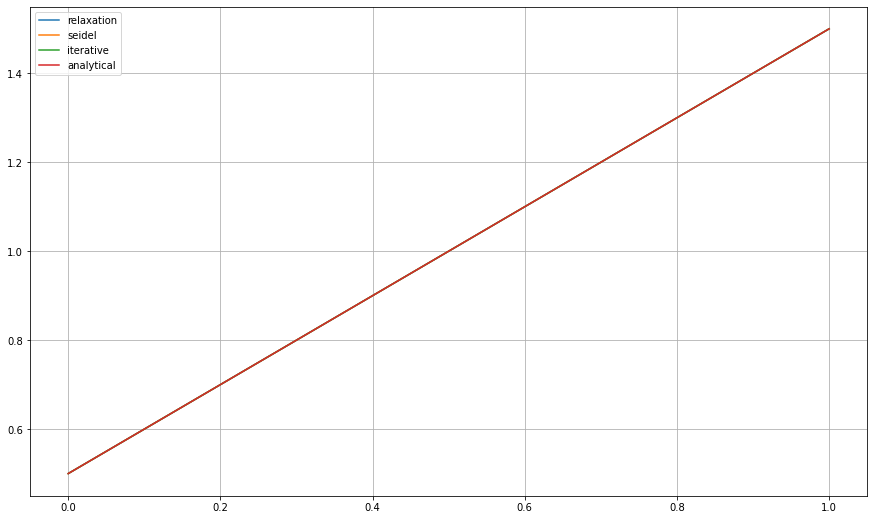

In [ ]:
plot_results(solutions, 0.5, xs, ys, hx, hy)

In [ ]:
solutions = {
    "relaxation": result_relaxation, 
    "seidel"    : result_seidel,
    "iterative" : result_iterative,
}

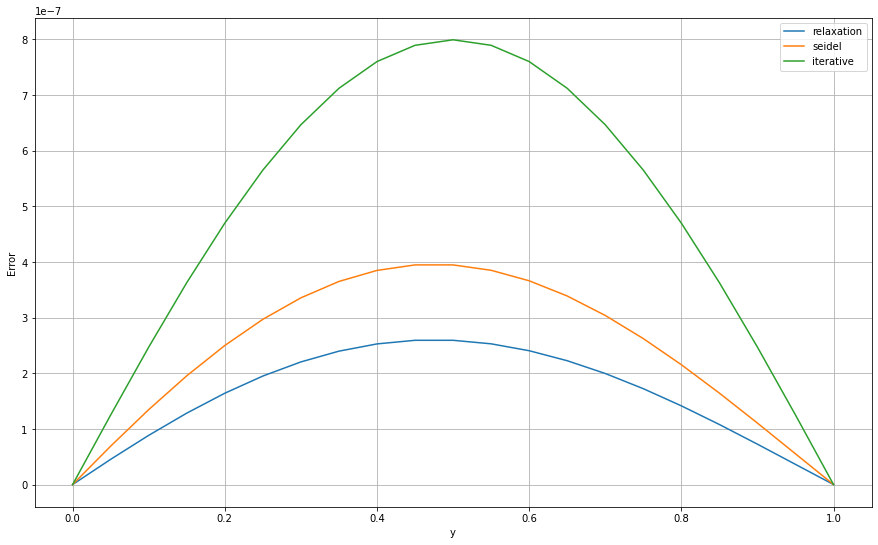

In [ ]:
plot_errors_from_y(solutions, ans, ys, hy)